## Imports

In [121]:
from __future__ import division
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt
import sys
from numba import jit
%matplotlib inline

## Functions we need

In [122]:
   # Stiffnes matrix
def lk():
    E = 1
    nu = 0.3
    k = np.array([1 / 2 - nu / 6, 1 / 8 + nu / 8, - 1 / 4 - nu / 12, - 1 / 8 + 3 * nu / 8, - 1 / 4 + nu / 12, - 1 / 8 - nu / 8,nu / 6,1 / 8 - 3 * nu / 8])
    KE  =  E / (1 - nu ** 2) * np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
    [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
    [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
    [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
    [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
    [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
    [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
    [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);
    return (KE)
    
    # Optimality criterion
def oc(nelx, nely, x, volfrac, dc, dv, g):
    l1 = 0
    l2 = 1e9
    move = 0.2
 
    # We need to reshape to perform vector operations
    xnew = np.zeros(nelx * nely)
    while (l2 - l1) / (l1 + l2) > 1e-3:
        lmid = 0.5 * (l2 + l1)
        xnew[:] =  np.maximum(0.0,np.maximum(x - move,np.minimum(1.0,np.minimum(x + move,x * np.sqrt( - dc / dv / lmid)))))
        gt = g + np.sum((dv * (xnew - x)))
        if gt > 0 :
            l1 = lmid
        else:
            l2 = lmid
    return (xnew,gt)

## Main

In [123]:
    def main(E0= 1.0, Emin = 1e-9, nelx = 120, nely = 40, volfrac = 0.35, penal = 3.0, rmin= 1.5, flag = 0):
        print("Minimum compliance problem with OC")
        print("ndes: " + str(nelx) + " x " + str(nely))
        print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin)  + ", penal: " + str(penal))
        print("Filter method: " + ["Sensitivity based","Density based"][flag])
    

        # dofs:
        ndof  =  2 * (nelx + 1) * (nely + 1)
        
        # Allocate design variables (as array), initialize and allocate sens.
        x = volfrac  *  np.ones(nely * nelx,dtype = float)
        xold = x.copy()
        xPhys = x.copy()
        
        g = 0 # must be initialized to use the NGuyen / Paulino OC approach
        dc = np.zeros((nely,nelx), dtype = float)
        
        # FE: Build the index vectors for the for coo matrix format.
        KE = lk()
        edofMat = np.zeros((nelx * nely,8),dtype = int)
        for elx in range(nelx):
            for ely in range(nely):
                el  =  ely + elx * nely
                n1 = (nely + 1) * elx + ely
                n2 = (nely + 1) * (elx + 1) + ely
                edofMat[el,:] = np.array([2 * n1 + 2, 2 * n1 + 3, 2 * n2 + 2, 2 * n2 + 3,2 * n2, 2 * n2 + 1, 2 * n1, 2 * n1 + 1])
        
        # Construct the index pointers for the coo format
        iK  =  np.kron(edofMat,np.ones((8,1))).flatten()
        jK  =  np.kron(edofMat,np.ones((1,8))).flatten()   
        
        # Filter: Build (and assemble) the index + data vectors for the coo matrix format
        nfilter = int(nelx * nely * ((2 * (np.ceil(rmin) - 1) + 1) ** 2))
        iH  =  np.zeros(nfilter)
        jH  =  np.zeros(nfilter)
        sH  =  np.zeros(nfilter)
        cc = 0
        for i in range(nelx):
            for j in range(nely):
                row = i * nely + j
                kk1 = int(np.maximum(i - (np.ceil(rmin) - 1),0))
                kk2 = int(np.minimum(i + np.ceil(rmin),nelx))
                ll1 = int(np.maximum(j - (np.ceil(rmin) - 1),0))
                ll2 = int(np.minimum(j + np.ceil(rmin),nely))
                for k in range(kk1,kk2):
                    for l in range(ll1,ll2):
                        col = k * nely + l
                        fac = rmin - np.sqrt(((i - k) * (i - k) + (j - l) * (j - l)))
                        iH[cc] = row
                        jH[cc] = col
                        sH[cc] = np.maximum(0.0,fac)
                        cc = cc + 1
                        
        # Finalize assembly and convert to csc format
        
        H = coo_matrix((sH,(iH,jH)),shape = (nelx * nely,nelx * nely)).tocsc()
        Hs = H.sum(1)
        
        # BC's and support
        dofs = np.arange(2 * (nelx + 1) * (nely + 1))
        fixed = np.union1d(dofs[0:2 * (nely + 1):2],np.array([2 * (nelx + 1) * (nely + 1) - 1]))
        free = np.setdiff1d(dofs,fixed)
        
        # Solution and RHS vectors
        f = np.zeros((ndof,1))
        u = np.zeros((ndof,1))
        # Set load
        f[1,0] =  - 1
        
        # Initialize plot and plot the initial design
        plt.ion() # Ensure that redrawing is possible
        fig, ax  =  plt.subplots()
        im  =  ax.imshow( - xPhys.reshape((nelx,nely)).T, cmap = 'gray', interpolation = 'none',norm = colors.Normalize(vmin =  - 1,vmax = 0))
        fig.show()
        
        # Set loop counter and gradient vectors 
        loop = 0
        change = 1
        max_iter = 2000
        dv  =  np.ones(nely * nelx)
        dc  =  np.ones(nely * nelx)
        ce  =  np.ones(nely * nelx)
        while change > 0.01 and loop < max_iter:
            loop = loop + 1 
            
            # Setup and solve FE problem
            sK = ((KE.flatten()[np.newaxis]).T * (Emin + (xPhys) ** penal * (E0 - Emin))).flatten(order = 'F')
            K  =  coo_matrix((sK, (iK, jK)),shape = (ndof, ndof)).tocsc()
            
            # Remove constrained dofs from matrix
            K  =  K[free,:][:,free]
            # Solve system 
            u[free,0] = spsolve(K,f[free,0])  
            
            # Objective and sensitivity
            ce[:]  =  (np.dot(u[edofMat].reshape(nelx * nely, 8),KE)  *  u[edofMat].reshape(nelx * nely, 8) ).sum(1)
            obj = ((Emin + xPhys ** penal * (E0 - Emin)) * ce ).sum()
            dc[:] = ( - penal * xPhys ** (penal - 1) * (E0 - Emin)) * ce
            dv[:]  =  np.ones(nely * nelx)
            
            # Sensitivity filtering:
            if flag == 0:
                dc[:]  =  np.asarray((H * (x * dc))[np.newaxis].T / Hs)[:, 0]  /  np.maximum(0.001, x)
            elif flag == 1:
                dc[:]  =  np.asarray(H * (dc[np.newaxis].T / Hs))[:, 0]
                dv[:]  =  np.asarray(H * (dv[np.newaxis].T / Hs))[:, 0]
                
            # Optimality criteria
            xold[:] = x
            (x[:],g) = oc(nelx, nely, x, volfrac, dc, dv, g)
            
            # Filter design variables
            if flag == 0:   xPhys[:] = x
            elif flag == 1:	xPhys[:] = np.asarray(H * x[np.newaxis].T / Hs)[:,0]
                
            # Compute the change by the inf. norm
            change = np.linalg.norm(x.reshape(nelx * nely,1) - xold.reshape(nelx * nely,1),np.inf)
            
            # Plot to screen
            im.set_array( - xPhys.reshape((nelx, nely)).T)
            fig.canvas.draw()
                        
            #print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(loop,obj,(g + volfrac * nelx * nely) / (nelx * nely),change))
        # Make sure the plot stays and that the shell remains
        plt.show()

Minimum compliance problem with OC
ndes: 120 x 40
volfrac: 0.35, rmin: 2.5, penal: 3.0
Filter method: Density based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


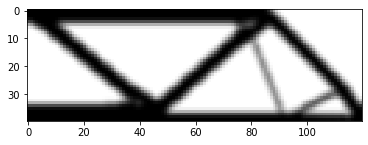

In [5]:
    if __name__  ==  "__main__":
        # Dnput parameters
        rmin = 2.5 # = 1.5
        flag = 1 # flag = = 0  -  >  constraint, flag = = 1  -  >  density

        main(rmin = rmin, flag = flag)

## Profile of our code

Minimum compliance problem with OC
ndes: 120 x 40
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


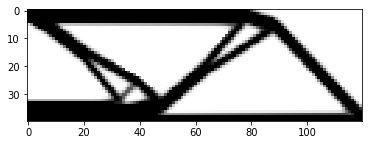

         5031319 function calls (4913637 primitive calls) in 31.299 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       32    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(all)
    10667    0.005    0.000    0.061    0.000 <__array_function__ internals>:2(amax)
    10458    0.006    0.000    0.067    0.000 <__array_function__ internals>:2(amin)
    10571    0.008    0.000    0.108    0.000 <__array_function__ internals>:2(any)
      204    0.000    0.000    0.017    0.000 <__array_function__ internals>:2(argsort)
     8300    0.006    0.000    0.059    0.000 <__array_function__ internals>:2(around)
       16    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_1d)
       22    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
     3750    0.003    0.000    0.051    0.000 <__array_function__ internals>:2(broadcast_arrays)
     3069    0.002    0.000  

     3407    0.002    0.000    0.005    0.000 font_manager.py:744(set_family)
     3407    0.005    0.000    0.009    0.000 font_manager.py:757(set_style)
     3407    0.003    0.000    0.006    0.000 font_manager.py:767(set_variant)
     3407    0.013    0.000    0.014    0.000 font_manager.py:776(set_weight)
     3407    0.006    0.000    0.008    0.000 font_manager.py:794(set_stretch)
     3407    0.009    0.000    0.012    0.000 font_manager.py:812(set_size)
     3407    0.001    0.000    0.001    0.000 font_manager.py:837(set_file)
       22    0.000    0.000    0.000    0.000 font_manager.py:858(copy)
     6814    0.002    0.000    0.003    0.000 font_manager.py:928(_normalize_font_family)
       12    0.000    0.000    0.099    0.008 formatters.py:220(catch_format_error)
       11    0.000    0.000    0.000    0.000 formatters.py:274(_get_type)
        9    0.000    0.000    0.099    0.011 formatters.py:331(__call__)
       11    0.000    0.000    0.000    0.000 formatters.py:35

   199713    0.026    0.000    0.026    0.000 {function RcParams.__getitem__ at 0x7f7ce0901290}
     2083    0.002    0.000    0.038    0.000 {function matrix.sum at 0x7f7cf96cbcb0}
        2    0.000    0.000    0.000    0.000 {method '__array_prepare__' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 {method '__array_wrap__' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 {method '__enter__' of '_thread.lock' objects}
        2    0.000    0.000    0.000    0.000 {method '__exit__' of '_thread.lock' objects}
        1    0.000    0.000    0.000    0.000 {method '__reduce_ex__' of 'object' objects}
       26    0.000    0.000    0.000    0.000 {method 'acquire' of '_thread.lock' objects}
        6    0.000    0.000    0.000    0.000 {method 'all' of 'numpy.generic' objects}
        2    0.000    0.000    0.000    0.000 {method 'all' of 'numpy.ndarray' objects}
      411    0.000    0.000    0.003    0.000 {method 'any' of 'numpy.ndar

NameError: name 'rrr' is not defined

In [49]:
import cProfile
cProfile.run('main(5)')

## JIT implementation

In [51]:
    @jit
    def main_jit(E0= 1.0, Emin = 1e-9, nelx = 120, nely = 40, volfrac = 0.35, penal = 3.0, rmin= 1.5, flag = 0):
        print("Minimum compliance problem with OC")
        print("ndes: " + str(nelx) + " x " + str(nely))
        print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin)  + ", penal: " + str(penal))
        print("Filter method: " + ["Sensitivity based","Density based"][flag])
    

        # dofs:
        ndof  =  2 * (nelx + 1) * (nely + 1)
        
        # Allocate design variables (as array), initialize and allocate sens.
        x = volfrac  *  np.ones(nely * nelx,dtype = float)
        xold = x.copy()
        xPhys = x.copy()
        
        g = 0 # must be initialized to use the NGuyen / Paulino OC approach
        dc = np.zeros((nely,nelx), dtype = float)
        
        # FE: Build the index vectors for the for coo matrix format.
        KE = lk()
        edofMat = np.zeros((nelx * nely,8),dtype = int)
        for elx in range(nelx):
            for ely in range(nely):
                el  =  ely + elx * nely
                n1 = (nely + 1) * elx + ely
                n2 = (nely + 1) * (elx + 1) + ely
                edofMat[el,:] = np.array([2 * n1 + 2, 2 * n1 + 3, 2 * n2 + 2, 2 * n2 + 3,2 * n2, 2 * n2 + 1, 2 * n1, 2 * n1 + 1])
        
        # Construct the index pointers for the coo format
        iK  =  np.kron(edofMat,np.ones((8,1))).flatten() # kron = kroneker product
        jK  =  np.kron(edofMat,np.ones((1,8))).flatten()   
        
        # Filter: Build (and assemble) the index + data vectors for the coo matrix format
        nfilter = int(nelx * nely * ((2 * (np.ceil(rmin) - 1) + 1) ** 2))
        iH  =  np.zeros(nfilter)
        jH  =  np.zeros(nfilter)
        sH  =  np.zeros(nfilter)
        cc = 0
        for i in range(nelx):
            for j in range(nely):
                row = i * nely + j
                kk1 = int(np.maximum(i - (np.ceil(rmin) - 1),0))
                kk2 = int(np.minimum(i + np.ceil(rmin),nelx))
                ll1 = int(np.maximum(j - (np.ceil(rmin) - 1),0))
                ll2 = int(np.minimum(j + np.ceil(rmin),nely))
                for k in range(kk1,kk2):
                    for l in range(ll1,ll2):
                        col = k * nely + l
                        fac = rmin - np.sqrt(((i - k) * (i - k) + (j - l) * (j - l)))
                        iH[cc] = row
                        jH[cc] = col
                        sH[cc] = np.maximum(0.0,fac)
                        cc = cc + 1
                        
        # Finalize assembly and convert to csc format
        
        H = coo_matrix((sH,(iH,jH)),shape = (nelx * nely,nelx * nely)).tocsc()
        Hs = H.sum(1)
        
        # BC's and support
        dofs = np.arange(2 * (nelx + 1) * (nely + 1))
        fixed = np.union1d(dofs[0:2 * (nely + 1):2],np.array([2 * (nelx + 1) * (nely + 1) - 1]))
        free = np.setdiff1d(dofs,fixed)
        
        # Solution and RHS vectors
        f = np.zeros((ndof,1))
        u = np.zeros((ndof,1))
        # Set load
        f[1,0] =  - 1
        
        # Initialize plot and plot the initial design
        plt.ion() # Ensure that redrawing is possible
        fig, ax  =  plt.subplots()
        im  =  ax.imshow( - xPhys.reshape((nelx,nely)).T, cmap = 'gray', interpolation = 'none',norm = colors.Normalize(vmin =  - 1,vmax = 0))
        fig.show()
        
        # Set loop counter and gradient vectors 
        loop = 0
        change = 1
        max_iter = 2000
        dv  =  np.ones(nely * nelx)
        dc  =  np.ones(nely * nelx)
        ce  =  np.ones(nely * nelx)
        while change > 0.01 and loop < max_iter:
            loop = loop + 1 
            
            # Setup and solve FE problem
            sK = ((KE.flatten()[np.newaxis]).T * (Emin + (xPhys) ** penal * (E0 - Emin))).flatten(order = 'F')
            K  =  coo_matrix((sK, (iK, jK)),shape = (ndof, ndof)).tocsc()
            
            # Remove constrained dofs from matrix
            K  =  K[free,:][:,free]
            # Solve system 
            u[free,0] = spsolve(K,f[free,0])  
            
            # Objective and sensitivity
            ce[:]  =  (np.dot(u[edofMat].reshape(nelx * nely, 8),KE)  *  u[edofMat].reshape(nelx * nely, 8) ).sum(1)
            obj = ((Emin + xPhys ** penal * (E0 - Emin)) * ce ).sum()
            dc[:] = ( - penal * xPhys ** (penal - 1) * (E0 - Emin)) * ce
            dv[:]  =  np.ones(nely * nelx)
            
            # Sensitivity filtering:
            if flag == 0:
                dc[:]  =  np.asarray((H * (x * dc))[np.newaxis].T / Hs)[:, 0]  /  np.maximum(0.001, x)
            elif flag == 1:
                dc[:]  =  np.asarray(H * (dc[np.newaxis].T / Hs))[:, 0]
                dv[:]  =  np.asarray(H * (dv[np.newaxis].T / Hs))[:, 0]
                
            # Optimality criteria
            xold[:] = x
            (x[:],g) = oc(nelx, nely, x, volfrac, dc, dv, g)
            
            # Filter design variables
            if flag == 0:   xPhys[:] = x
            elif flag == 1:	xPhys[:] = np.asarray(H * x[np.newaxis].T / Hs)[:,0]
                
            # Compute the change by the inf. norm
            change = np.linalg.norm(x.reshape(nelx * nely,1) - xold.reshape(nelx * nely,1),np.inf)
            
            # Plot to screen
            im.set_array( - xPhys.reshape((nelx, nely)).T)
            fig.canvas.draw()
                        
            #print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(loop,obj,(g + volfrac * nelx * nely) / (nelx * nely),change))
        # Make sure the plot stays and that the shell remains
        plt.show()

## Comparison between numpy and JIT

Minimum compliance problem with OC
ndes: 30 x 10
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


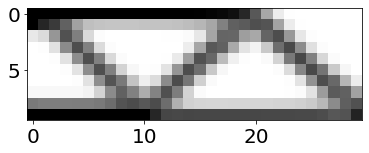

<ipython-input-51-ef914c296ca8>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "main_jit" failed type inference due to: Untyped global name 'lk': cannot determine Numba type of <class 'function'>

File "<ipython-input-51-ef914c296ca8>", line 21:
def main_jit(E0= 1.0, Emin = 1e-9, nelx = 120, nely = 40, volfrac = 0.35, penal = 3.0, rmin= 1.5, flag = 0):
    <source elided>
    # FE: Build the index vectors for the for coo matrix format.
    KE = lk()
    ^

  @jit
<ipython-input-51-ef914c296ca8>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "main_jit" failed type inference due to: Untyped global name 'lk': cannot determine Numba type of <class 'function'>

File "<ipython-input-51-ef914c296ca8>", line 21:
def main_jit(E0= 1.0, Emin = 1e-9, nelx = 120, nely = 40, volfrac = 0.35, penal = 3.0, rmin= 1.5, flag = 0):
    <source elided>
    # FE: Build the index vectors for the 

Minimum compliance problem with OC
ndes: 30 x 10
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
<ipython-input-51-ef914c296ca8>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "main_jit" failed type inference due to: Untyped global name 'coo_matrix': cannot determine Numba type of <class 'type'>

File "<ipython-input-51-ef914c296ca8>", line 90:
def main_jit(E0= 1.0, Emin = 1e-9, nelx = 120, nely = 40, volfrac = 0.35, penal = 3.0, rmin= 1.5, flag = 0):
    <source elided>
        sK = ((KE.flatten()[np.newaxis]).T * (Emin + (xPhys) ** penal * (E0 - Emin))).flatten(order = 'F')
        K  =  coo_matrix((sK, (iK, jK)),shape = (ndof, ndof)).tocsc()
        ^

  @jit
/home/alexh3/anaconda3/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "ma

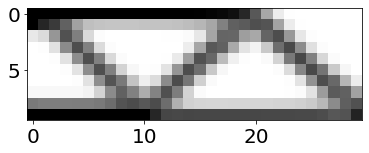

Minimum compliance problem with OC
ndes: 60 x 20
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


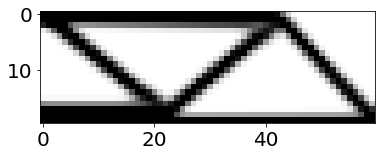

Minimum compliance problem with OC
ndes: 60 x 20
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


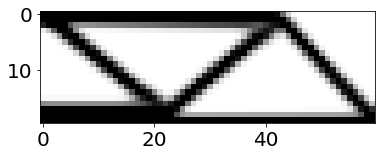

Minimum compliance problem with OC
ndes: 90 x 30
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


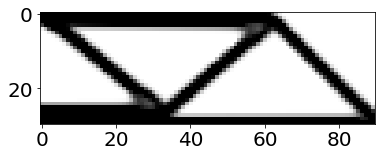

Minimum compliance problem with OC
ndes: 90 x 30
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


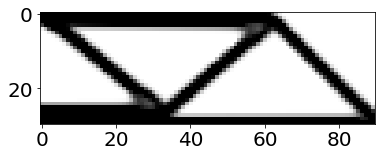

Minimum compliance problem with OC
ndes: 120 x 40
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


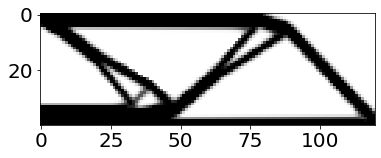

Minimum compliance problem with OC
ndes: 120 x 40
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


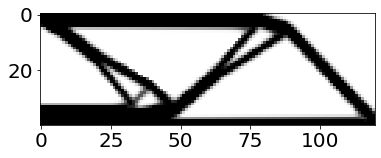

Minimum compliance problem with OC
ndes: 150 x 50
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


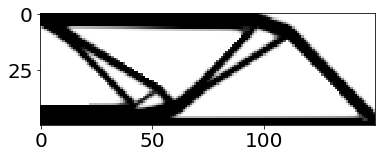

Minimum compliance problem with OC
ndes: 150 x 50
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


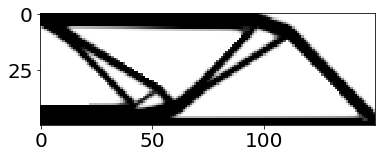

Minimum compliance problem with OC
ndes: 180 x 60
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


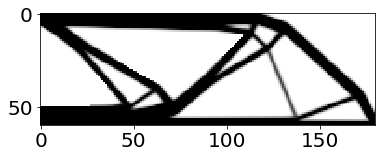

Minimum compliance problem with OC
ndes: 180 x 60
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


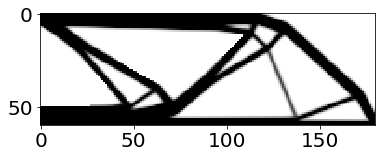

Minimum compliance problem with OC
ndes: 210 x 70
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


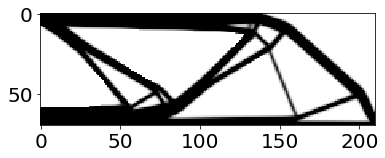

Minimum compliance problem with OC
ndes: 210 x 70
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


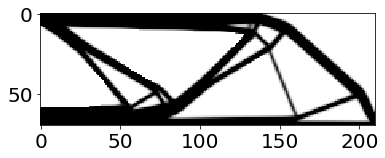

Minimum compliance problem with OC
ndes: 240 x 80
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


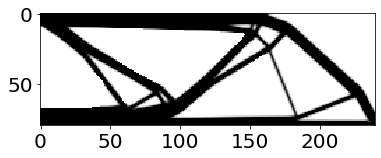

Minimum compliance problem with OC
ndes: 240 x 80
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


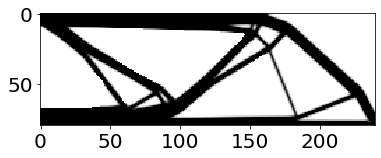

Minimum compliance problem with OC
ndes: 270 x 90
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


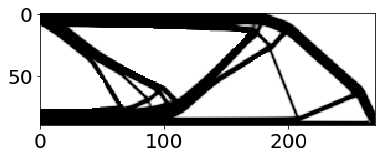

Minimum compliance problem with OC
ndes: 270 x 90
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


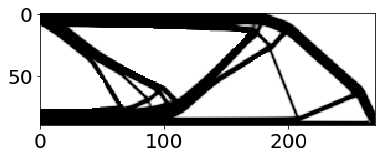

Minimum compliance problem with OC
ndes: 300 x 100
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


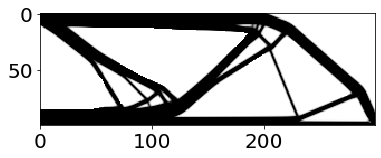

Minimum compliance problem with OC
ndes: 300 x 100
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


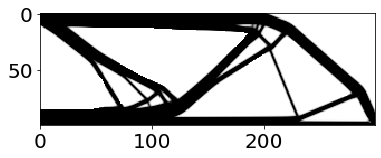

In [68]:
import time
time_numpy = []
time_jit = []
start_time = 0

Range_y = np.array([10 * (i + 1) for i in range(10)])
Range_x = np.array([30 * (i + 1) for i in range(10)])
for i in range(10):
    
    start_time = time.time()
    main(nelx=Range_x[i], nely = Range_y[i])
    time_numpy.append(time.time() - start_time)

    start_time = time.time()
    main_jit(nelx=Range_x[i], nely = Range_y[i])
    time_jit.append(time.time() - start_time)

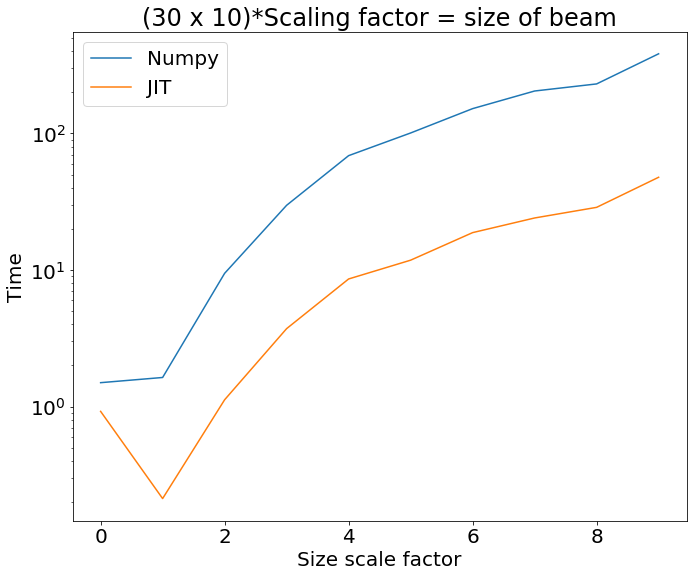

In [88]:
plt.figure(figsize=(11, 9))
plt.rcParams.update({'font.size': 20})
time_jit_ = [time_jit[i]/8 for i in range(len(time_jit))]
plt.plot(list(range(10)), time_numpy, label='Numpy')
plt.plot(list(range(10)), time_jit_, label='JIT')
plt.legend(loc='best')
plt.title('(30 x 10)*Scaling factor = size of beam')
plt.xlabel('Size scale factor')
plt.ylabel('Time')
plt.yscale('log')
plt.savefig('Numpy vs JIT.png')
plt.show()

## Speedup

In [112]:
l = []
with open('time.txt') as f:
    l = f.read().splitlines()
result = [float(l[0])/float(i) for i in l]

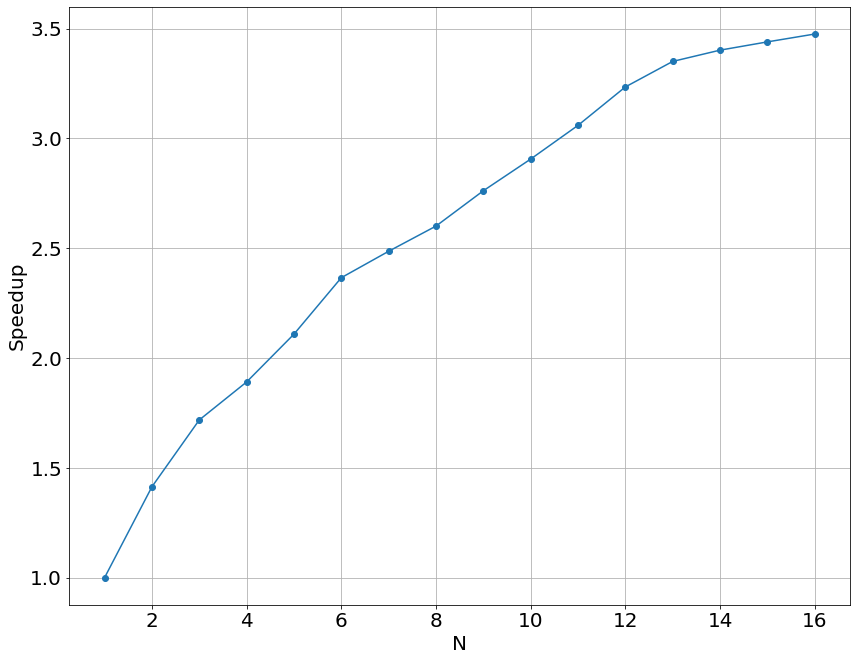

In [117]:
plt.figure(figsize = (14,11))
plt.rcParams.update({'font.size': 20})
plt.plot(range(1, len(result)+1),result, '.-',markersize = 12)
plt.ylabel('Speedup')
plt.xlabel('N')
plt.grid('on')
plt.savefig('Speedup.png')
plt.show()

## Efficiency

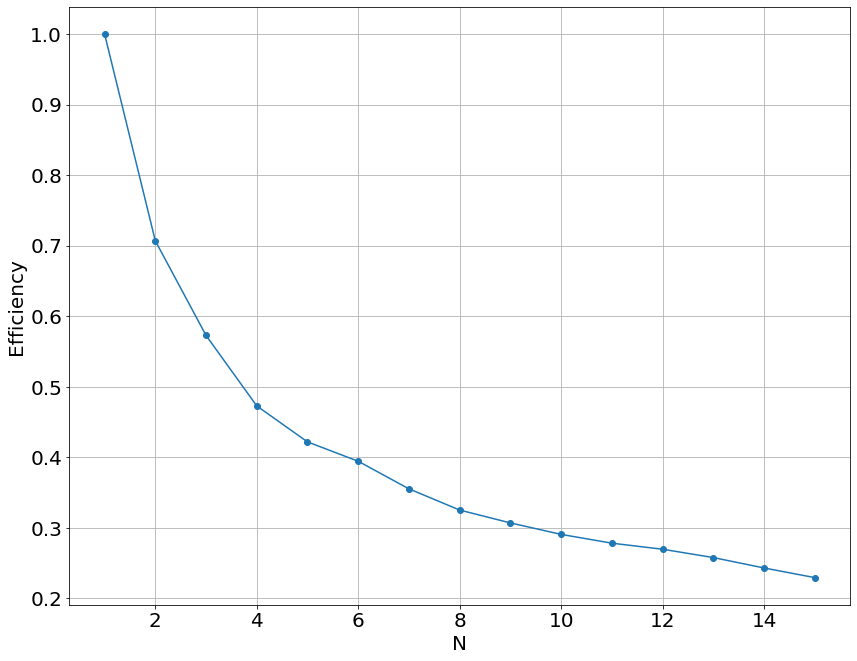

In [118]:
ef = [result[i]/(i+1) for i in range(len(result)-1)]
plt.figure(figsize = (14,11))
plt.rcParams.update({'font.size': 20})
plt.plot(range(1, len(ef)+1),ef, '.-',markersize = 12)
plt.ylabel('Efficiency')
plt.xlabel('N')
plt.grid('on')
plt.savefig('Efficiency.png')

plt.show()

In [142]:
    def History(E0= 1.0, Emin = 1e-9, nelx = 120, nely = 40, volfrac = 0.35, penal = 3.0, rmin= 1.5, flag = 0):
        print("Minimum compliance problem with OC")
        print("ndes: " + str(nelx) + " x " + str(nely))
        print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin)  + ", penal: " + str(penal))
        print("Filter method: " + ["Sensitivity based","Density based"][flag])
    
        v_history = []
        s_history = []
        # dofs:
        ndof  =  2 * (nelx + 1) * (nely + 1)
        
        # Allocate design variables (as array), initialize and allocate sens.
        x = volfrac  *  np.ones(nely * nelx,dtype = float)
        xold = x.copy()
        xPhys = x.copy()
        
        g = 0 # must be initialized to use the NGuyen / Paulino OC approach
        dc = np.zeros((nely,nelx), dtype = float)
        
        # FE: Build the index vectors for the for coo matrix format.
        KE = lk()
        edofMat = np.zeros((nelx * nely,8),dtype = int)
        for elx in range(nelx):
            for ely in range(nely):
                el  =  ely + elx * nely
                n1 = (nely + 1) * elx + ely
                n2 = (nely + 1) * (elx + 1) + ely
                edofMat[el,:] = np.array([2 * n1 + 2, 2 * n1 + 3, 2 * n2 + 2, 2 * n2 + 3,2 * n2, 2 * n2 + 1, 2 * n1, 2 * n1 + 1])
        
        # Construct the index pointers for the coo format
        iK  =  np.kron(edofMat,np.ones((8,1))).flatten()
        jK  =  np.kron(edofMat,np.ones((1,8))).flatten()   
        
        # Filter: Build (and assemble) the index + data vectors for the coo matrix format
        nfilter = int(nelx * nely * ((2 * (np.ceil(rmin) - 1) + 1) ** 2))
        iH  =  np.zeros(nfilter)
        jH  =  np.zeros(nfilter)
        sH  =  np.zeros(nfilter)
        cc = 0
        for i in range(nelx):
            for j in range(nely):
                row = i * nely + j
                kk1 = int(np.maximum(i - (np.ceil(rmin) - 1),0))
                kk2 = int(np.minimum(i + np.ceil(rmin),nelx))
                ll1 = int(np.maximum(j - (np.ceil(rmin) - 1),0))
                ll2 = int(np.minimum(j + np.ceil(rmin),nely))
                for k in range(kk1,kk2):
                    for l in range(ll1,ll2):
                        col = k * nely + l
                        fac = rmin - np.sqrt(((i - k) * (i - k) + (j - l) * (j - l)))
                        iH[cc] = row
                        jH[cc] = col
                        sH[cc] = np.maximum(0.0,fac)
                        cc = cc + 1
                        
        # Finalize assembly and convert to csc format
        
        H = coo_matrix((sH,(iH,jH)),shape = (nelx * nely,nelx * nely)).tocsc()
        Hs = H.sum(1)
        
        # BC's and support
        dofs = np.arange(2 * (nelx + 1) * (nely + 1))
        fixed = np.union1d(dofs[0:2 * (nely + 1):2],np.array([2 * (nelx + 1) * (nely + 1) - 1]))
        free = np.setdiff1d(dofs,fixed)
        
        # Solution and RHS vectors
        f = np.zeros((ndof,1))
        u = np.zeros((ndof,1))
        # Set load
        f[1,0] =  - 1
        
        # Initialize plot and plot the initial design
        plt.ion() # Ensure that redrawing is possible
        fig, ax  =  plt.subplots()
        im  =  ax.imshow( - xPhys.reshape((nelx,nely)).T, cmap = 'gray', interpolation = 'none',norm = colors.Normalize(vmin =  - 1,vmax = 0))
        fig.show()
        
        # Set loop counter and gradient vectors 
        loop = 0
        change = 1
        max_iter = 2000
        dv  =  np.ones(nely * nelx)
        dc  =  np.ones(nely * nelx)
        ce  =  np.ones(nely * nelx)
        while change > 0.01 and loop < max_iter:
            loop = loop + 1 
            
            # Setup and solve FE problem
            sK = ((KE.flatten()[np.newaxis]).T * (Emin + (xPhys) ** penal * (E0 - Emin))).flatten(order = 'F')
            K  =  coo_matrix((sK, (iK, jK)),shape = (ndof, ndof)).tocsc()
            
            # Remove constrained dofs from matrix
            K  =  K[free,:][:,free]
            # Solve system 
            u[free,0] = spsolve(K,f[free,0])  
            
            # Objective and sensitivity
            ce[:]  =  (np.dot(u[edofMat].reshape(nelx * nely, 8),KE)  *  u[edofMat].reshape(nelx * nely, 8) ).sum(1)
            obj = ((Emin + xPhys ** penal * (E0 - Emin)) * ce ).sum()
            dc[:] = ( - penal * xPhys ** (penal - 1) * (E0 - Emin)) * ce
            dv[:]  =  np.ones(nely * nelx)
            
            # Sensitivity filtering:
            if flag == 0:
                dc[:]  =  np.asarray((H * (x * dc))[np.newaxis].T / Hs)[:, 0]  /  np.maximum(0.001, x)
            elif flag == 1:
                dc[:]  =  np.asarray(H * (dc[np.newaxis].T / Hs))[:, 0]
                dv[:]  =  np.asarray(H * (dv[np.newaxis].T / Hs))[:, 0]
                
            # Optimality criteria
            xold[:] = x
            (x[:],g) = oc(nelx, nely, x, volfrac, dc, dv, g)
            
            # Filter design variables
            if flag == 0:   xPhys[:] = x
            elif flag == 1:	xPhys[:] = np.asarray(H * x[np.newaxis].T / Hs)[:,0]
                
            # Compute the change by the inf. norm
            change = np.linalg.norm(x.reshape(nelx * nely,1) - xold.reshape(nelx * nely,1),np.inf)
            
            # Plot to screen
            im.set_array( - xPhys.reshape((nelx, nely)).T)
            fig.canvas.draw()
            v_history.append((g + volfrac * nelx * nely) / (nelx * nely))    
            s_history.append(ce)  
            #print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(loop,obj,(g + volfrac * nelx * nely) / (nelx * nely),change))
        # Make sure the plot stays and that the shell remains
        plt.show()
        return v_history, s_history, g

Minimum compliance problem with OC
ndes: 120 x 40
volfrac: 0.35, rmin: 1.5, penal: 3.0
Filter method: Sensitivity based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


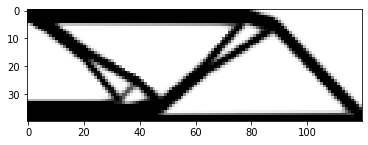

Minimum compliance problem with OC
ndes: 120 x 40
volfrac: 0.35, rmin: 2.5, penal: 3.0
Filter method: Density based


/home/alexh3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


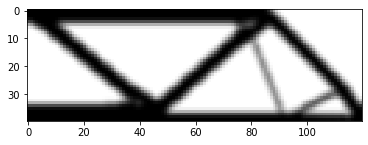

In [143]:
flag_0_history, stress_0_history, g1 = History() 
flag_1_history, stress_1_history, g2 = History(rmin = 2.5, flag = 1) 

In [ ]:
plt.plot(flag_0_history, stress_0_history[0])
plt.plot(flag_1_history, stress_1_history[0])

In [137]:
stress_0_history

[array([3.45852424, 0.8361244 , 0.38668818, ..., 0.37314933, 0.94718255,
        2.34491431]),
 array([3.45852424, 0.8361244 , 0.38668818, ..., 0.37314933, 0.94718255,
        2.34491431]),
 array([3.45852424, 0.8361244 , 0.38668818, ..., 0.37314933, 0.94718255,
        2.34491431]),
 array([3.45852424, 0.8361244 , 0.38668818, ..., 0.37314933, 0.94718255,
        2.34491431]),
 array([3.45852424, 0.8361244 , 0.38668818, ..., 0.37314933, 0.94718255,
        2.34491431]),
 array([3.45852424, 0.8361244 , 0.38668818, ..., 0.37314933, 0.94718255,
        2.34491431]),
 array([3.45852424, 0.8361244 , 0.38668818, ..., 0.37314933, 0.94718255,
        2.34491431]),
 array([3.45852424, 0.8361244 , 0.38668818, ..., 0.37314933, 0.94718255,
        2.34491431]),
 array([3.45852424, 0.8361244 , 0.38668818, ..., 0.37314933, 0.94718255,
        2.34491431]),
 array([3.45852424, 0.8361244 , 0.38668818, ..., 0.37314933, 0.94718255,
        2.34491431]),
 array([3.45852424, 0.8361244 , 0.38668818, ..., 0

In [144]:
print(g1, g2)

-0.03630450006046321 0.018832604248863495
